In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os

In [3]:
import librosa
import numpy as np

def extract_gorilla_segments_from_excel_with_mfcc(excel_file_path, audio_files_dir, segment_length=None, n_mfcc=13):
    # Load Excel file
    excel_data = pd.ExcelFile(excel_file_path)

    # Initialize dictionaries to store MFCC features and labels
    mfccs_dict = {}
    labels_dict = {}
    max_segment_length = 0  # Initialize maximum segment length

    # Iterate over each sheet in the Excel file
    for sheet_name in excel_data.sheet_names:
        common_part = sheet_name.split('_')[0]

        # Find corresponding audio file
        audio_file_name = None
        for file_name in os.listdir(audio_files_dir):
            if common_part in file_name:
                audio_file_name = os.path.splitext(file_name)[0]
                break

        if audio_file_name is None:
            print(f"Audio file not found for sheet '{sheet_name}'. Skipping...")
            continue

        # Load audio
        audio_file_path = os.path.join(audio_files_dir, f"{audio_file_name}.wav")
        y, sr = librosa.load(audio_file_path, sr=None, mono=True)

        # Read selection table from the current sheet
        selection_table = excel_data.parse(sheet_name)

        # Initialize lists to store MFCC features and labels
        mfccs = []
        labels = []

        for index, row in selection_table.iterrows():
            begin_time = row['Begin Time (s)']
            end_time = row['End Time (s)']
            label = row['Gorilla Sound']

            begin_sample = int(begin_time * sr)
            end_sample = int(end_time * sr)

            if segment_length is None:
                segment_length = end_sample - begin_sample
            else:
                max_segment_length = max(max_segment_length, end_sample - begin_sample)  # Update max segment length

            # Extract segment and pad/truncate to segment_length
            segment = y[begin_sample:end_sample]
            padded_segment = np.zeros(segment_length)
            padded_segment[:min(len(segment), segment_length)] = segment[:min(len(segment), segment_length)]

            # Extract MFCCs for the segment
            mfcc = librosa.feature.mfcc(y=padded_segment, sr=sr, n_mfcc=n_mfcc)
            mfcc = mfcc.T  # Transpose for correct time step ordering

            # Append MFCC and label
            mfccs.append(mfcc)
            labels.append(label)

        # Store MFCC features and labels in dictionaries
        mfccs_dict[audio_file_name] = mfccs
        labels_dict[audio_file_name] = labels

    return mfccs_dict, labels_dict, max_segment_length

In [4]:
# Example usage
excel_file_path = '/content/drive/MyDrive/Gorilla Project/input_dir/Selections/GORILLA SELECTIONSS.xlsx'
audio_files_dir = '/content/drive/MyDrive/Gorilla Project/input_dir/Gorilla Sounds'
mfccs_dict, labels_dict, max_segment_length = extract_gorilla_segments_from_excel_with_mfcc(excel_file_path, audio_files_dir)


In [5]:
max_segment_length

281092

In [6]:
# Combine data from all files into a single dataset
def prepare_rnn_input(mfccs_dict, labels_dict):
    all_mfccs = []
    all_labels = []

    for audio_file_name in mfccs_dict.keys():
        mfccs = mfccs_dict[audio_file_name]
        labels = labels_dict[audio_file_name]

        all_mfccs.extend(mfccs)
        all_labels.extend(labels)

    # Convert to numpy arrays
    X = np.array(all_mfccs)
    y = np.array(all_labels)

    print(f"Input data shape: {X.shape}, Labels shape: {y.shape}")

    return X, y

In [7]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers

# Prepare the RNN input
X, y = prepare_rnn_input(mfccs_dict, labels_dict)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Input data shape: (579, 34, 13), Labels shape: (579,)


In [8]:
from collections import Counter

# Check if the dataset is balanced
# Using Counter
label_counts = Counter(y)
print("Label counts using Counter:")
print(label_counts)

print("Value counts using Counter:")
value_counts = Counter(y_test)
print(value_counts)

Label counts using Counter:
Counter({1: 335, 0: 244})
Value counts using Counter:
Counter({1: 70, 0: 46})


In [9]:
# Verify shapes of extracted features
print("Train features shape:", X_train.shape)  # Expecting (num_samples, feature_dim)
print("Train labels shape:", y_train.shape)
print("Test features shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train features shape: (463, 34, 13)
Train labels shape: (463,)
Test features shape: (116, 34, 13)
Test labels shape: (116,)


In [10]:
import random
# Set the random seeds for reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
from tensorflow.keras import layers, models, regularizers, optimizers
def create_model(input_shape):
    model = models.Sequential([
        layers.Bidirectional(layers.LSTM(128, return_sequences=True, kernel_regularizer=regularizers.l2(0.01)), input_shape=input_shape),
        layers.Dropout(0.5),  # Adjusted dropout rate
        layers.Bidirectional(layers.LSTM(64, return_sequences=False, kernel_regularizer=regularizers.l2(0.01))),
        layers.Dropout(0.5),  # Adjusted dropout rate
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Added L2 regularization
        layers.Dropout(0.5),  # Adjusted dropout rate
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 34, 256)             │         145,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 34, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 318,081 (1.21 MB)

 Trainable params: 318,081 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_save_path='model.h5'):
    """
    Train and evaluate the RNN model.

    Args:
        X_train (np.array): Training features.
        y_train (np.array): Training labels.
        X_test (np.array): Test features.
        y_test (np.array): Test labels.
        model_save_path (str): Path to save the trained model.
    """
    # Create and compile the model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Plot learning curves
    def plot_learning_curve(history):
        plt.figure(figsize=(12, 6))

        # Plot training & validation accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plot training & validation loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()

    plot_learning_curve(history)

    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    # Generate predictions
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)

    # Classification report
    print(classification_report(y_test, y_pred, target_names=['Non-Gorilla', 'Gorilla']))

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Gorilla', 'Gorilla'], yticklabels=['Non-Gorilla', 'Gorilla'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # Save the model
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    # Optionally, load the model (if needed later)
    # loaded_model = models.load_model(model_save_path)
    # print("Model loaded successfully!")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 239ms/step - accuracy: 0.5184 - loss: 6.7710 - val_accuracy: 0.6034 - val_loss: 5.3545
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 0.5126 - loss: 5.0170 - val_accuracy: 0.6034 - val_loss: 3.9882
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.5709 - loss: 3.7465 - val_accuracy: 0.6034 - val_loss: 3.0359
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6142 - loss: 2.8630 - val_accuracy: 0.6121 - val_loss: 2.3700
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 265ms/step - accuracy: 0.5792 - loss: 2.2481 - val_accuracy: 0.6379 - val_loss: 1.9143
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.6501 - loss: 1.8324 - val_accuracy: 0.4741 - val_loss: 1.6989
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.5999 - loss: 1.6106 - val_accuracy: 0.5862 - val_loss: 1.4292
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 0.6597 - loss: 1.3534 - val_accuracy: 0.6293 - val

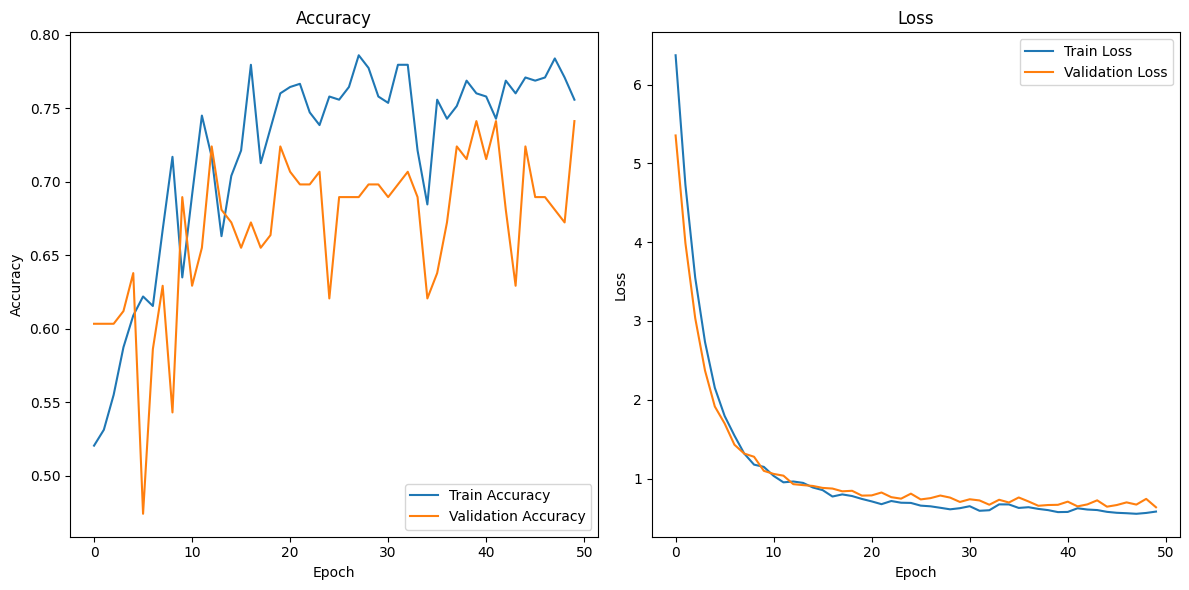

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7320 - loss: 0.6778
Test Accuracy: 74.14%


3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step 

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
              precision    recall  f1-score   support

 Non-Gorilla       0.75      0.52      0.62        46
     Gorilla       0.74      0.89      0.81        70

    accuracy                           0.74       116
   macro avg       0.74      0.70      0.71       116
weighted avg       0.74      0.74      0.73       116



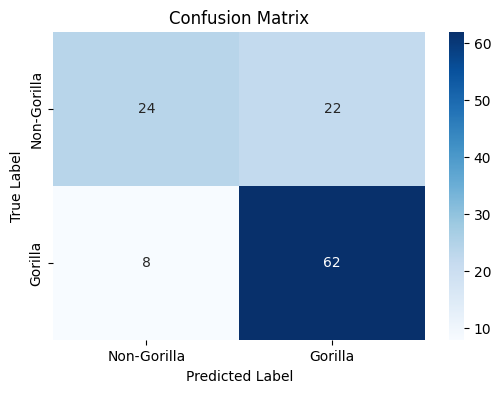

Model saved to /content/drive/MyDrive/Gorilla Project/out_dir/gorilla_sound_classifier.h5


In [15]:
# import numpy as np
# import tensorflow as tf
# import random

# np.random.seed(42)
# random.seed(42)
# tf.random.set_seed(42)

# X_train, y_train, X_test, y_test should be defined
train_and_evaluate_model(X_train, y_train, X_test, y_test, model_save_path='/content/drive/MyDrive/Gorilla Project/out_dir/gorilla_sound_classifier.h5')

In [16]:
import pandas as pd
import os
import shutil

# Function definitions
def get_training_audio_files_from_excel(excel_file_path, audio_files_dir):
    # Load Excel file
    excel_data = pd.ExcelFile(excel_file_path)

    # Extract audio file names from the Excel sheet names
    training_files = set()

    for sheet_name in excel_data.sheet_names:
        common_part = sheet_name.split('_')[0].strip()

        # Check if common_part is at the beginning of any audio file before an underscore
        for file_name in os.listdir(audio_files_dir):
            file_prefix = file_name.split('_')[0]
            if file_prefix == common_part and file_name.endswith('.wav'):
                training_files.add(file_name)

    return training_files

def create_directories(base_dir):
    training_dir = os.path.join(base_dir, 'training_audio_files')
    unseen_dir = os.path.join(base_dir, 'unseen_audio_files')

    os.makedirs(training_dir, exist_ok=True)
    os.makedirs(unseen_dir, exist_ok=True)

    return training_dir, unseen_dir

def copy_files(file_names, source_dir, target_dir):
    for file_name in file_names:
        src_file = os.path.join(source_dir, file_name)
        dest_file = os.path.join(target_dir, file_name)
        shutil.copy(src_file, dest_file)
        #print(f"Copied {file_name} to {target_dir}")

def copy_unseen_files(all_files, training_files, source_dir, target_dir):
    unseen_files = set(all_files) - set(training_files)

    for file_name in unseen_files:
        src_file = os.path.join(source_dir, file_name)
        dest_file = os.path.join(target_dir, file_name)
        shutil.copy(src_file, dest_file)
        #print(f"Copied {file_name} to {target_dir}")

# Define paths
excel_file_path = '/content/drive/MyDrive/Gorilla Project/input_dir/Selections/GORILLA SELECTIONSS.xlsx'
audio_files_dir = '/content/drive/MyDrive/Gorilla Project/input_dir/Gorilla Sounds'
base_dir = '/content/drive/MyDrive/Gorilla Project/input_dir'

# Get the training audio files
training_files = get_training_audio_files_from_excel(excel_file_path, audio_files_dir)

# Create directories
training_dir, unseen_dir = create_directories(base_dir)

# Copy training files
copy_files(training_files, audio_files_dir, training_dir)

# List all audio files in the source directory
all_files = [f for f in os.listdir(audio_files_dir) if f.endswith('.wav')]

# Copy unseen files
copy_unseen_files(all_files, training_files, audio_files_dir, unseen_dir)


In [17]:
def segment_audio_with_timestamps(audio, sr, segment_length=0.5):
    segment_samples = int(segment_length * sr)
    total_samples = len(audio)
    segments = []
    timestamps = []  # To store the start and end times for each segment

    for start in range(0, total_samples, segment_samples):
        end = start + segment_samples
        segment = audio[start:end]

        # Calculate start and end times in seconds
        start_time = start / sr
        end_time = min(end / sr, total_samples / sr)  # Ensure it doesn't exceed the total duration

        # If the segment is shorter than required, pad it
        if len(segment) < segment_samples:
            segment = np.pad(segment, (0, segment_samples - len(segment)), mode='constant')

        segments.append(segment)
        timestamps.append((start_time, end_time))  # Store the start and end times

    return segments, timestamps

In [18]:
def extract_mfcc_from_segments_with_timestamps(audio_file_path, segment_length=0.5, n_mfcc=13):
    audio, sr = librosa.load(audio_file_path, sr=None)
    segments, timestamps = segment_audio_with_timestamps(audio, sr, segment_length)

    mfcc_segments = []
    for segment in segments:
        mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=n_mfcc)
        mfcc_segments.append(mfcc.T)  # Transpose to match (timesteps, n_mfcc)

    return mfcc_segments, timestamps

In [19]:
def prepare_unseen_data_with_segments_and_timestamps(unseen_audio_dir, segment_length=0.5, n_mfcc=13):
    unseen_mfccs = []
    unseen_file_names = []
    segment_info = []
    segment_timestamps = []

    for file_name in os.listdir(unseen_audio_dir):
        if file_name.endswith('.wav'):
            audio_file_path = os.path.join(unseen_audio_dir, file_name)
            mfcc_segments, timestamps = extract_mfcc_from_segments_with_timestamps(audio_file_path, segment_length, n_mfcc)

            unseen_mfccs.extend(mfcc_segments)
            unseen_file_names.extend([file_name] * len(mfcc_segments))  # Repeat filename for each segment
            segment_info.extend([(file_name, i) for i in range(len(mfcc_segments))])
            segment_timestamps.extend(timestamps)  # Append the timestamps for each segment

    X_unseen = np.array(unseen_mfccs)  # Shape: (num_segments, timesteps, n_mfcc)
    return X_unseen, unseen_file_names, segment_info, segment_timestamps

In [22]:
# Load the trained model
from tensorflow.keras.models import load_model

model_path = '/content/drive/MyDrive/Gorilla Project/out_dir/gorilla_sound_classifier.h5'  # Update the path to your trained model
model = load_model(model_path)

# Process the unseen data
unseen_audio_dir = '/content/drive/MyDrive/Gorilla Project/input_dir/unseen_audio_files'  # Update with the correct path
X_unseen, unseen_file_names, segment_info, segment_timestamps = prepare_unseen_data_with_segments_and_timestamps(unseen_audio_dir)

# Ensure the input shape matches the model's input requirements
print(f"Shape of unseen data: {X_unseen.shape}")  # Should match the model's expected input shape

# Make predictions on unseen data
predictions = model.predict(X_unseen)

# Convert predictions to binary labels (0 or 1)
threshold = 0.5
binary_predictions = [1 if pred >= threshold else 0 for pred in predictions]

# Save predictions with corresponding file names, segment indices, and timestamps
import pandas as pd

output = pd.DataFrame({
    'FileName': unseen_file_names,
    'SegmentIndex': [info[1] for info in segment_info],
    'StartTime': [ts[0] for ts in segment_timestamps],  # Start time of the segment
    'EndTime': [ts[1] for ts in segment_timestamps],    # End time of the segment
    'Prediction': binary_predictions
})


# Save to CSV
output_path = '/content/drive/MyDrive/Gorilla Project/out_dir/unseen_predictions_with_timestamps.csv'  # Update if necessary
output.to_csv(output_path, index=False)
output.head(15)

Shape of unseen data: (5152, 44, 13)
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step


,FileName,SegmentIndex,StartTime,EndTime,Prediction
0,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,0,0.0,0.500000,0
1,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,1,0.5,1.000000,1
2,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,2,1.0,1.500000,1
3,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,3,1.5,2.000000,1
4,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,4,2.0,2.500000,1
5,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,5,2.5,3.000000,1
6,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,6,3.0,3.500000,1
7,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,7,3.5,4.000000,0
8,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,8,4.0,4.500000,0
9,243_Mobimba_Bemba_11.wav_transposed_+12_ReaEQ.wav,9,4.5,4.656145,1


**Combining the unseen data with the training data to have the full dataset with the timestamps**

In [24]:
import pandas as pd
import os

def extract_training_data_from_excel(excel_file_path, audio_files_dir):
    # Load Excel file
    excel_data = pd.ExcelFile(excel_file_path)
    training_info = []

    # Iterate over each sheet
    for sheet_name in excel_data.sheet_names:
        common_part = sheet_name.split('_')[0]
        # Find corresponding audio file with full name
        for file_name in os.listdir(audio_files_dir):
            if file_name.startswith(common_part) and file_name.endswith('.wav'):
                full_audio_file_name = file_name
                break
        else:
            print(f"Audio file not found for sheet '{sheet_name}'. Skipping...")
            continue

        # Read selection table from the current sheet
        selection_table = excel_data.parse(sheet_name)
        for index, row in selection_table.iterrows():
            begin_time = row['Begin Time (s)']
            end_time = row['End Time (s)']
            label = row['Gorilla Sound']
            training_info.append({
                'FileName': full_audio_file_name,
                'SegmentIndex': index,  # Assuming each row is a segment
                'StartTime': begin_time,
                'EndTime': end_time,
                'Prediction': label
            })

    return pd.DataFrame(training_info)

# Define paths
excel_file_path = '/content/drive/MyDrive/Gorilla Project/input_dir/Selections/GORILLA SELECTIONSS.xlsx'
audio_files_dir = '/content/drive/MyDrive/Gorilla Project/input_dir/Gorilla Sounds'

# Extract training data
training_data_df = extract_training_data_from_excel(excel_file_path, audio_files_dir)

In [25]:
# Combine training data and unseen data
combined_df = pd.concat([training_data_df, output], ignore_index=True)

# Save combined DataFrame to a CSV file
combined_csv_path = '/content/drive/MyDrive/Gorilla Project/out_dir/all_audio_with_timestamps.csv'
combined_df.to_csv(combined_csv_path, index=False)

In [27]:
combined_df.head(15)

,FileName,SegmentIndex,StartTime,EndTime,Prediction
0,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,0,2.299632,2.686504,1
1,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,1,0.522715,0.934636,1
2,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,2,4.385392,4.621968,1
3,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,3,3.703495,3.817609,1
4,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,4,1.043183,1.811360,1
5,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,5,4.123766,4.218397,1
6,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,6,4.665170,5.672707,1
7,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,7,4.221180,4.374259,1
8,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,8,1.827265,2.277366,1
9,01_Balema_Bemba_1.wav_transposed_+12_ReaEQ.wav,9,2.768867,3.637242,0
